In [1]:
# Импорт библиотек
import os
import glob
import cv2
import csv
import re
import numpy as np
import pandas as pd
import openpyxl
import subprocess
import mammoth
import matplotlib.pyplot as plt
import tempfile

from datetime import datetime

from docx import Document

from paddleocr import PaddleOCR

import pytesseract

In [2]:
# --- Инициализация OCR (CPU) ---
ocr = PaddleOCR(use_textline_orientation=True, lang="en")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/haykarutyunyan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/haykarutyunyan/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/haykarutyunyan/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/haykarutyunyan/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manuall

In [3]:
# --- Функция извлечения всех изображений из DOCX файлов (с рекурсией по подкаталогам) ---
def extract_images_from_docx_folder(input_dir, output_dir):
    """
    Рекурсивно проходит по папкам внутри input_dir:
    - В папке заказчика лежат подпапки с номерами производств;
    - В них — DOCX-файлы.
    Извлекает все изображения и сохраняет их в output_dir
    с уникальными именами.
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"📂 Поиск DOCX в: {input_dir}")

    # Счётчик обработанных файлов и изображений
    total_docs = 0
    total_images = 0

    for root, _, files in os.walk(input_dir):
        for file in files:
            if not file.lower().endswith(".docx"):
                continue

            total_docs += 1
            docx_path = os.path.join(root, file)
            print(f"\n📄 Обработка файла: {docx_path}")

            try:
                document = Document(docx_path)
            except Exception as e:
                print(f"  ⚠️ Ошибка чтения {docx_path}: {e}")
                continue

            # Определяем имя заказчика и номер производства по структуре пути
            rel_path = os.path.relpath(root, input_dir)
            customer_parts = rel_path.split(os.sep)
            if len(customer_parts) >= 2:
                customer = customer_parts[0]
                production = customer_parts[1]
            else:
                customer = customer_parts[0] if customer_parts else "unknown"
                production = "unknown"

            # Папка сохранения для изображений конкретного заказа
            save_dir = output_dir
            os.makedirs(save_dir, exist_ok=True)

            img_count = 0
            for rel in document.part._rels:
                rel_obj = document.part._rels[rel]
                if "image" in rel_obj.target_ref:
                    img_count += 1
                    total_images += 1
                    img_data = rel_obj.target_part.blob
                    img_name = f"{os.path.splitext(file)[0]}_img{img_count}.png"
                    img_path = os.path.join(save_dir, img_name)
                    with open(img_path, "wb") as f:
                        f.write(img_data)
                    print(f"  ✅ Сохранено изображение: {img_path}")

            if img_count == 0:
                print("  ⚠️ В этом файле изображений не найдено.")

    # --- Итоговое сообщение ---
    if total_docs == 0:
        print("\n🚫 В указанной папке и её подпапках не найдено ни одного DOCX-файла.")
    else:
        print(f"\n✅ Обработка завершена. Найдено файлов: {total_docs}, сохранено изображений: {total_images}")

In [4]:
def crop_and_save_images(input_dir, output_dir):
    """
    Рекурсивно проходит по структуре:
    input_dir / <заказчик> / <номер_производства> / *.png
    и сохраняет обрезанные изображения в output_dir
    с той же структурой подпапок.
    """
    for root, _, files in os.walk(input_dir):
        # Относительный путь от корня input_dir
        rel_path = os.path.relpath(root, input_dir)
        save_dir = os.path.join(output_dir, rel_path)
        os.makedirs(save_dir, exist_ok=True)

        # Фильтруем изображения
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        for filename in image_files:
            input_path = os.path.join(root, filename)
            
            # Считываем изображение
            img = cv2.imread(input_path)
            if img is None:
                print(f"❌ Ошибка: не удалось загрузить изображение {input_path}")
                continue
            
            # Проверяем, что высота достаточна
            if img.shape[0] < 127:
                print(f"⚠️ Пропущено: высота изображения меньше 127 пикселей ({filename})")
                continue
            
            # Обрезаем сверху и снизу по надобности
            cropped_img = img[6:]

            # Сохраняем с тем же именем + "_cropped"
            name, ext = os.path.splitext(filename)
            output_path = os.path.join(save_dir, f"{name}_cropped{ext}")
            
            # Сохраняем изображение
            cv2.imwrite(output_path, cropped_img, [cv2.IMWRITE_PNG_COMPRESSION, 0])
            print(f"✅ Сохранено: {output_path}")

In [5]:
# --- Обрезание заголовка ---
def crop_title_from_cropped_image(img):
    # Обрезаем изображение
    h, w = img.shape[:2]
    roi = img[:45, :int(w/2.4)]
    return roi

In [6]:
def extract_title_from_crop_image(img):
    """
    Оцифровывает заголовок с обрезанного изображения.
    """
    print("\n[DEBUG] extract_title_from_crop_image:")
    print("Тип входных данных:", type(img))

    if isinstance(img, np.ndarray):
        print("Размер изображения:", img.shape, "| dtype:", img.dtype)
    else:
        print("Значение img:", img)

    if img is None:
        print("[DEBUG] img is None → пропуск OCR")
        return ""

    if isinstance(img, str):
        print("[DEBUG] img — это строка (путь). Пробую загрузить через cv2.imread()...")
        img = cv2.imread(img)
        if img is None:
            print("[DEBUG] Не удалось прочитать изображение. Пропуск.")
            return ""

    # Основная обработка
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray, alpha=2.0, beta=-50)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 15, 11)

    try:
        print("[DEBUG] Запуск pytesseract.image_to_string()...")
        text = pytesseract.image_to_string(binary, config="--psm 7").strip()
        print("[DEBUG] OCR result:", repr(text))
    except Exception as e:
        print(f"[ERROR] OCR failed: {e}")
        text = ""

    return text

In [7]:
def remove_blue_lines_inpaint(img):
    # 1. Создаём маску в HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_blue = np.array([110, 50, 50])
    upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_red = np.array([110, 180, 80])   # H-5, немного снижаем S,V
    upper_red = np.array([120, 235, 170])  # H+5, немного допускаем повышение яркости
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # --- Итоговая маска ---
    mask = cv2.bitwise_or(mask_blue, mask_red)

    # 2. Применяем inpainting к исходному BGR
    img_cleaned = cv2.inpaint(img, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    #plt.figure(figsize=(10, 15))
    ## После inpainting
    #plt.imshow(cv2.cvtColor(img_cleaned, cv2.COLOR_BGR2RGB))
    #plt.title("После удаления линий (Inpainting)")
    #plt.axis("off")

    #plt.tight_layout()
    #plt.show()
    
    return img_cleaned

In [8]:
# --- Функция извлечения сенсоров без деления на квадранты ---
def extract_sensors_no_quadrants(
    img,
    input_path=None,
    output_dir="/Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_mask",
    ocr=None,
    save_masks=True,
    min_width=90,
    min_height=17,
    debug=True
):
    
    h, w = img.shape[:2]
    
    sensors = []

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # --- Фиолетовый ---
    lower_purple = np.array([120, 80, 50])
    upper_purple = np.array([150, 255, 255])
    mask_purple = cv2.inRange(hsv, lower_purple, upper_purple)

    # --- Бирюзовый ---
    lower_cyan = np.array([85, 150, 150])
    upper_cyan = np.array([100, 255, 255])
    mask_cyan = cv2.inRange(hsv, lower_cyan, upper_cyan)

    # --- Белый ---
    lower_white = np.array([0, 0, 250])
    upper_white = np.array([180, 15, 255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    # --- Светло-зеленый ---
    lower_greenl = np.array([85, 118, 118])
    upper_greenl = np.array([95, 138, 138])
    mask_green_light = cv2.inRange(hsv, lower_greenl, upper_greenl)
    
    # --- Тёмно-зеленый ---
    lower_greend = np.array([55, 245, 186])
    upper_greend = np.array([65, 255, 206])
    mask_green_dark = cv2.inRange(hsv, lower_greend, upper_greend)

    # --- Тёмно-серый ---
    lower_gray = np.array([0, 0, 187])
    upper_gray = np.array([180, 5, 197])
    mask_gray_dark = cv2.inRange(hsv, lower_gray, upper_gray)

    # --- Жёлтый ---
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # --- Красный (широкий диапазон) ---
    lower_red = np.array([0, 150, 150])
    upper_red = np.array([10, 255, 255])
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # --- Итоговая маска ---
    mask = cv2.bitwise_or(mask_purple, mask_cyan)
    mask = cv2.bitwise_or(mask, mask_white)
    mask = cv2.bitwise_or(mask, mask_green_light)
    mask = cv2.bitwise_or(mask, mask_green_dark)
    mask = cv2.bitwise_or(mask, mask_gray_dark)
    mask = cv2.bitwise_or(mask, mask_yellow)
    mask = cv2.bitwise_or(mask, mask_red)

    # --- Применяем маску к изображению
    mask_multicolor = cv2.bitwise_and(img, img, mask=mask)

    if save_masks:
        if input_path is not None:
            filename = os.path.basename(input_path)
            name, ext = os.path.splitext(filename)
        else:
            name = "scheme"
        mask_filename = f"{name}_mask{ext}"
        
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(os.path.join(output_dir, mask_filename), mask_multicolor)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return []

    rois, positions = [], []

    filtered_contours = []
    
    for contour in contours:
        
        x, y, w_box, h_box = cv2.boundingRect(contour)
        if w_box < min_width or h_box < min_height:
            continue
        
        if h_box > min_height:
            h_box = min_height

        if h_box / w_box > 1.5:  # слишком вытянуто по вертикали
            continue

        filtered_contours.append(contour)
        
        # --- Без расширения ---
        y_min, y_max = y, y + h_box
        x_min, x_max = x, x + w_box
    
        rois.append(img[y_min:y_max, x_min:x_max])
        positions.append((x_min, y_min, x_max - x_min, y_max - y_min))

    # --- Вызываем OCR один раз ---
    if rois and ocr is not None:
        ocr_results = ocr.predict(rois)
    else:
        ocr_results = [{'rec_texts': ['?'], 'rec_scores': [0]}]*len(rois)

    # --- Консольный вывод и формирование сенсоров ---
    for ((xx, yy, ww, hh), ocr_result) in zip(positions, ocr_results):
            text = ocr_result['rec_texts'][0] if ocr_result['rec_texts'] else '?'
            score = ocr_result['rec_scores'][0] if ocr_result['rec_scores'] else 0
            
            # Добавляем в список сенсоров
            sensors.append({
                "text": text,
                "x": xx,
                "y": yy,
                "w": ww,
                "h": hh,
                "score": score
            })
        
    # --- Визуализация только если debug=True ---
    if debug:
        debug_img = img.copy()
        for sensor in sensors:
            cv2.rectangle(debug_img, (sensor['x'], sensor['y']),
                          (sensor['x'] + sensor['w'], sensor['y'] + sensor['h']),
                          (0, 255, 0), 2)
            label = f"{sensor['text']} ({sensor['x']},{sensor['y']},{sensor['w']},{sensor['h']})"
            cv2.putText(debug_img, label, (sensor['x'], sensor['y']-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

        print(f"Всего ROI, прошедших фильтры: {len(rois)}")
        plt.figure(figsize=(12, 12))
        for i, roi_img in enumerate(rois):
            plt.subplot(10, 10, i+1)  # сетка, подстраивай под количество ROI
            plt.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"ROI {i+1}")
        plt.tight_layout()
        plt.show()

        # Отображение через matplotlib
        debug_img_rgb = cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 12))
        plt.imshow(debug_img_rgb)
        plt.axis('off')
        plt.title('Области, попавшие в оцифровку')
        plt.show()

        # Сохраняем изображение с визуализацией
        vis_filename = f"{name}_ocr_debug{ext}"
        cv2.imwrite(os.path.join(output_dir, vis_filename), debug_img)

    # --- Консольный вывод ---
    for idx, sensor in enumerate(sensors):
        print(f"Сенсор {idx+1}: '{sensor['text']}' (score: {sensor['score']:.2f}) - "
              f"координаты: x={sensor['x']}, y={sensor['y']}, w={sensor['w']}, h={sensor['h']}")

    return sensors

✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./343lubeoil_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./340p-34091_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./340k-34003_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./340sealgas_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./343p-34391_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./343sealgas_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./340lubeoil_cropped.PNG
✅ Сохранено: /Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png/./343k-34303_cropped.PNG

[DEBUG] extract_title_from_crop_image:
Тип входных данных: <class 'numpy.ndarray'>
Размер изображения: (45, 800, 3) | dtype: uint8
[DEBUG] Запуск pytesseract.image_to_string()...
[DEBUG] OCR result: 

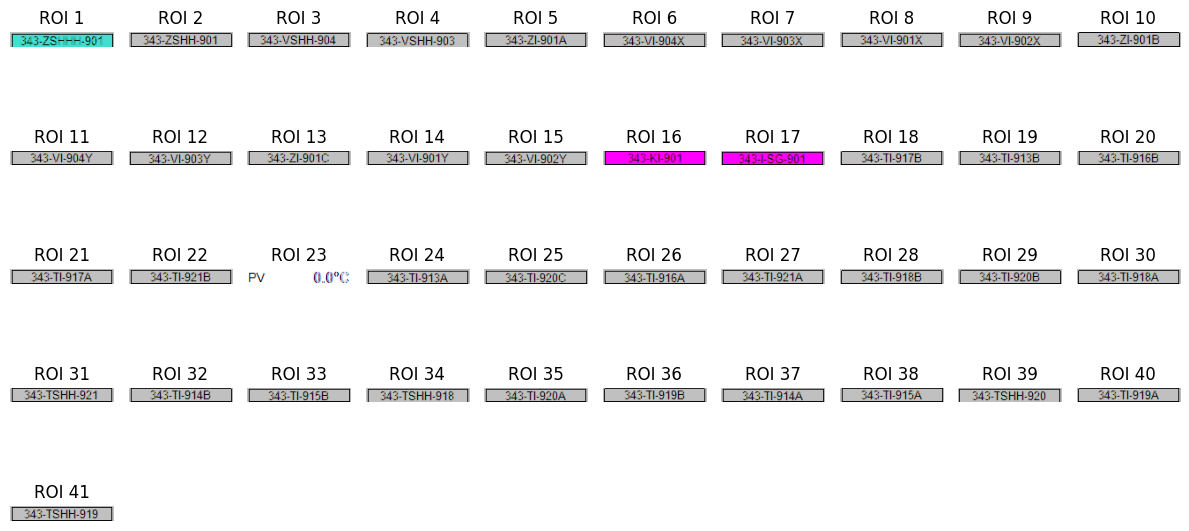

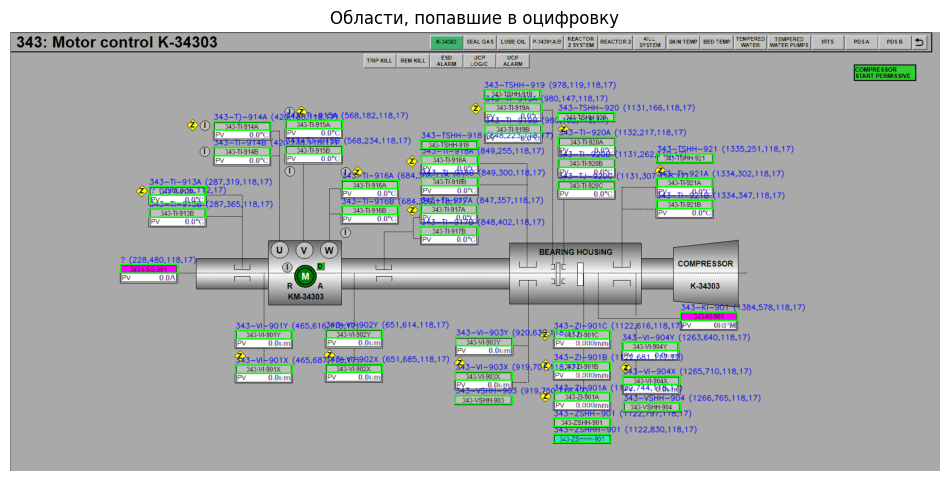

Сенсор 1: '343-ZSHHH-901' (score: 1.00) - координаты: x=1122, y=830, w=118, h=17
Сенсор 2: '343-ZSHH-901' (score: 1.00) - координаты: x=1122, y=797, w=118, h=17
Сенсор 3: '343-VSHH-904' (score: 1.00) - координаты: x=1266, y=765, w=118, h=17
Сенсор 4: '343-VSHH-903' (score: 1.00) - координаты: x=919, y=750, w=118, h=17
Сенсор 5: '343-ZI-901A' (score: 1.00) - координаты: x=1122, y=744, w=118, h=17
Сенсор 6: '343-VI-904X' (score: 0.99) - координаты: x=1265, y=710, w=118, h=17
Сенсор 7: '343-VI-903X' (score: 1.00) - координаты: x=919, y=701, w=118, h=17
Сенсор 8: '343-VI-901X' (score: 1.00) - координаты: x=465, y=687, w=118, h=17
Сенсор 9: '343-VI-902X' (score: 0.97) - координаты: x=651, y=685, w=118, h=17
Сенсор 10: '343-ZI-901B' (score: 0.99) - координаты: x=1122, y=681, w=117, h=17
Сенсор 11: '343-VI-904Y' (score: 1.00) - координаты: x=1263, y=640, w=118, h=17
Сенсор 12: '343-VI-903Y' (score: 1.00) - координаты: x=920, y=630, w=118, h=17
Сенсор 13: '343-ZI-901C' (score: 0.99) - координа

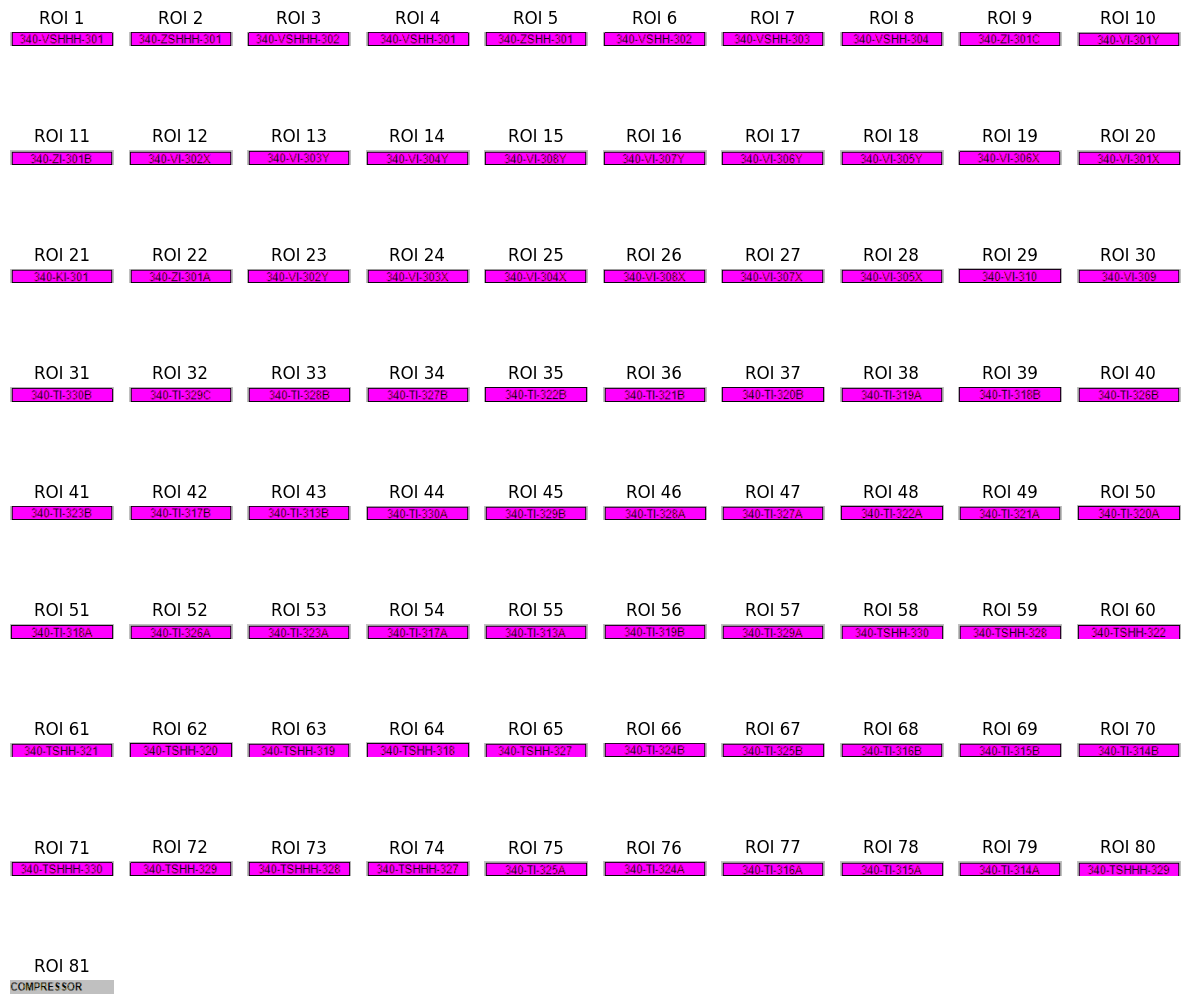

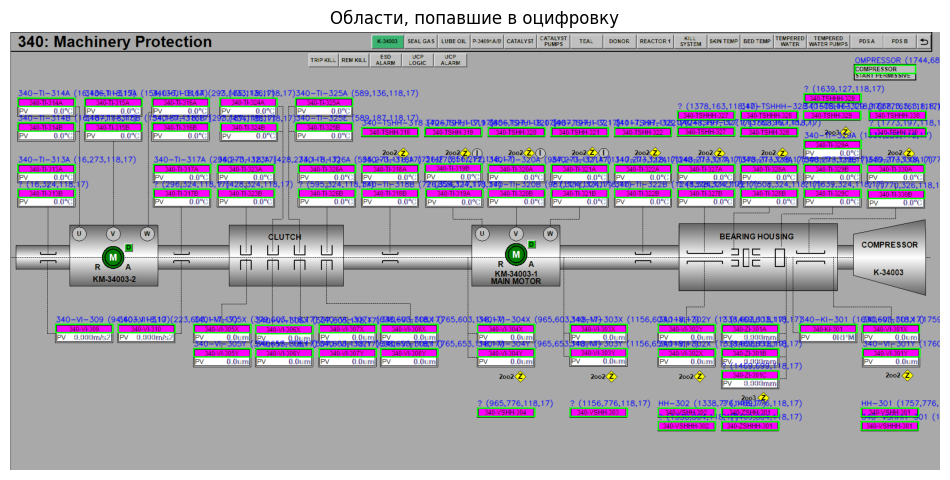

Сенсор 1: '340-VSHHH-301' (score: 0.96) - координаты: x=1757, y=804, w=118, h=17
Сенсор 2: '?' (score: 0.00) - координаты: x=1469, y=804, w=118, h=17
Сенсор 3: '?' (score: 0.00) - координаты: x=1338, y=804, w=118, h=17
Сенсор 4: 'HH-301' (score: 1.00) - координаты: x=1757, y=776, w=118, h=17
Сенсор 5: '?' (score: 0.00) - координаты: x=1469, y=776, w=118, h=17
Сенсор 6: 'HH-302' (score: 1.00) - координаты: x=1338, y=776, w=118, h=17
Сенсор 7: '?' (score: 0.00) - координаты: x=1156, y=776, w=118, h=17
Сенсор 8: '?' (score: 0.00) - координаты: x=965, y=776, w=118, h=17
Сенсор 9: '?' (score: 0.00) - координаты: x=1469, y=699, w=118, h=17
Сенсор 10: '340-VI-301Y' (score: 0.99) - координаты: x=1760, y=653, w=118, h=17
Сенсор 11: '?' (score: 0.00) - координаты: x=1469, y=653, w=118, h=17
Сенсор 12: '340-VI-302X' (score: 0.98) - координаты: x=1338, y=653, w=118, h=17
Сенсор 13: '340-VI-303Y' (score: 0.99) - координаты: x=1156, y=653, w=118, h=17
Сенсор 14: '340-VI-304Y' (score: 0.99) - координ

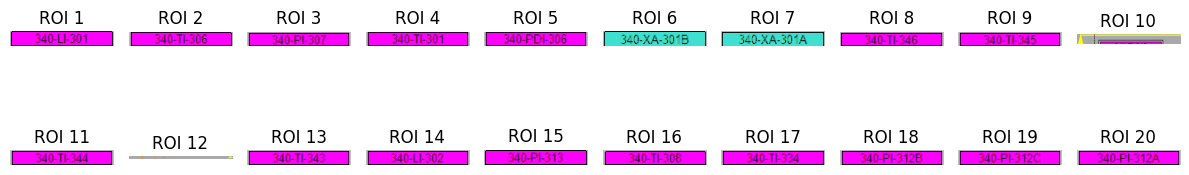

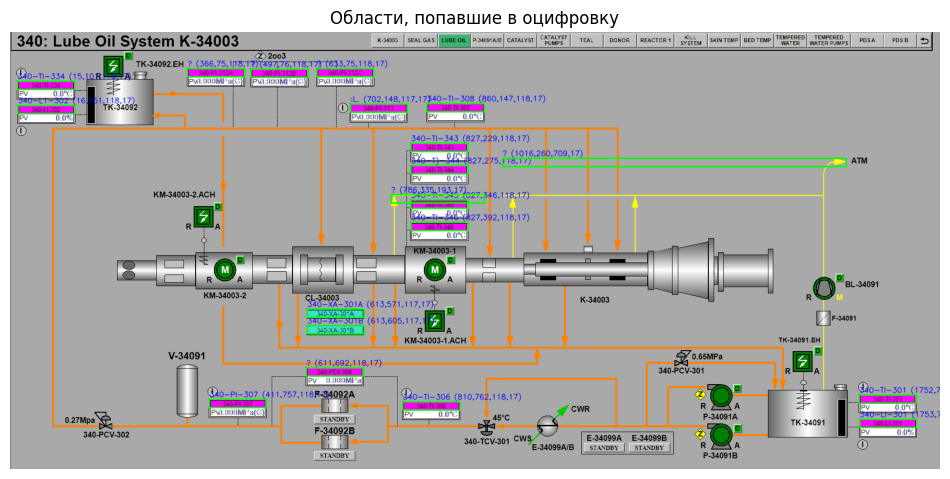

Сенсор 1: '340-LI-301' (score: 0.99) - координаты: x=1753, y=798, w=117, h=17
Сенсор 2: '340-TI-306' (score: 0.95) - координаты: x=810, y=762, w=118, h=17
Сенсор 3: '340-PI-307' (score: 0.97) - координаты: x=411, y=757, w=118, h=17
Сенсор 4: '340-Tl-301' (score: 0.97) - координаты: x=1752, y=748, w=118, h=17
Сенсор 5: '?' (score: 0.00) - координаты: x=611, y=692, w=118, h=17
Сенсор 6: '340-XA-301B' (score: 1.00) - координаты: x=613, y=605, w=117, h=17
Сенсор 7: '340-XA-301A' (score: 1.00) - координаты: x=613, y=571, w=117, h=17
Сенсор 8: '340-TI-346' (score: 0.98) - координаты: x=827, y=392, w=118, h=17
Сенсор 9: '340-TI-345' (score: 0.95) - координаты: x=827, y=346, w=118, h=17
Сенсор 10: '?' (score: 0.00) - координаты: x=786, y=335, w=193, h=17
Сенсор 11: '340-T)-344' (score: 0.94) - координаты: x=827, y=275, w=118, h=17
Сенсор 12: '?' (score: 0.00) - координаты: x=1016, y=260, w=709, h=17
Сенсор 13: '340-TI-343' (score: 0.97) - координаты: x=827, y=229, w=118, h=17
Сенсор 14: '340-L

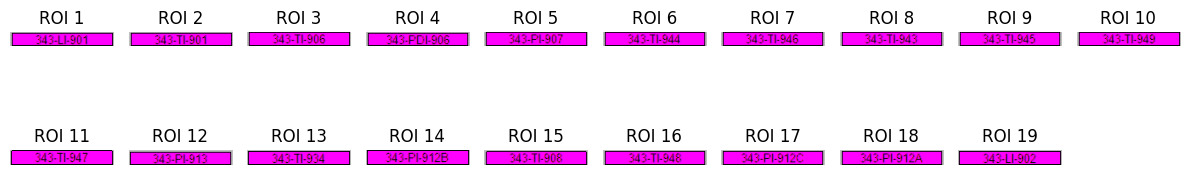

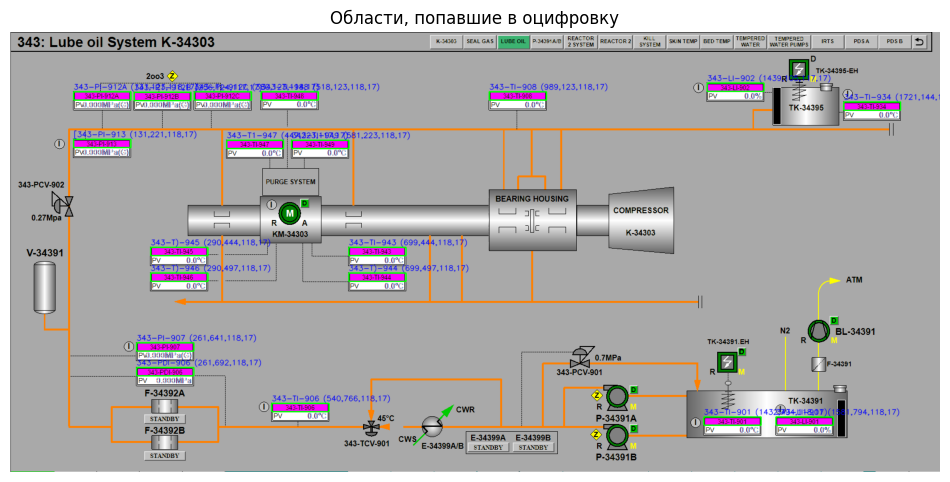

Сенсор 1: '343-LI-901' (score: 0.99) - координаты: x=1581, y=794, w=118, h=17
Сенсор 2: '343-TI-901' (score: 0.94) - координаты: x=1432, y=794, w=118, h=17
Сенсор 3: '343-TI-906' (score: 0.97) - координаты: x=540, y=766, w=118, h=17
Сенсор 4: '343-PDI-906' (score: 1.00) - координаты: x=261, y=692, w=118, h=17
Сенсор 5: '343-PI-907' (score: 0.96) - координаты: x=261, y=641, w=118, h=17
Сенсор 6: '343-T)-944' (score: 0.99) - координаты: x=699, y=497, w=118, h=17
Сенсор 7: '343-T)-946' (score: 0.98) - координаты: x=290, y=497, w=118, h=17
Сенсор 8: '343-TI-943' (score: 0.90) - координаты: x=699, y=444, w=118, h=17
Сенсор 9: '343-T)-945' (score: 0.96) - координаты: x=290, y=444, w=118, h=17
Сенсор 10: '343-TI-949' (score: 0.97) - координаты: x=581, y=223, w=118, h=17
Сенсор 11: '343-T1-947' (score: 0.96) - координаты: x=447, y=223, w=117, h=17
Сенсор 12: '[343-PI-913' (score: 0.94) - координаты: x=131, y=221, w=118, h=17
Сенсор 13: '343-TI-934' (score: 0.99) - координаты: x=1721, y=144, w=

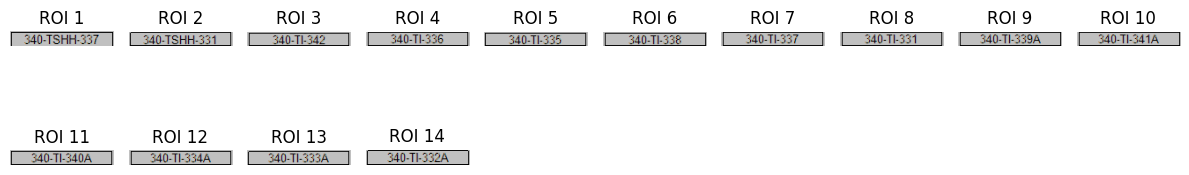

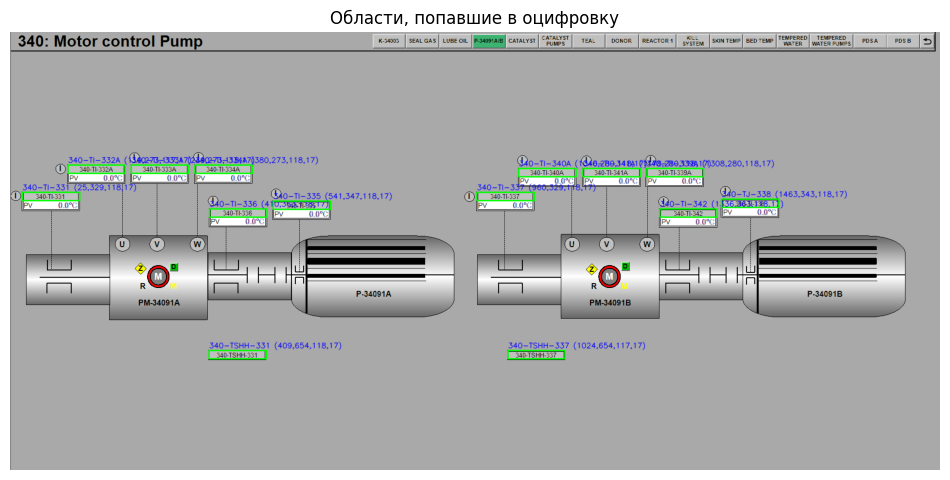

Сенсор 1: '340-TSHH-337' (score: 1.00) - координаты: x=1024, y=654, w=117, h=17
Сенсор 2: '340-TSHH-331' (score: 1.00) - координаты: x=409, y=654, w=118, h=17
Сенсор 3: '340-TI-342' (score: 0.99) - координаты: x=1336, y=363, w=118, h=17
Сенсор 4: '340-TI-336' (score: 0.98) - координаты: x=410, y=363, w=118, h=17
Сенсор 5: '340-TI-335' (score: 0.99) - координаты: x=541, y=347, w=118, h=17
Сенсор 6: '340-TJ-338' (score: 0.95) - координаты: x=1463, y=343, w=118, h=17
Сенсор 7: '340-TI-337' (score: 0.98) - координаты: x=960, y=329, w=118, h=17
Сенсор 8: '340-TI-331' (score: 0.96) - координаты: x=25, y=329, w=118, h=17
Сенсор 9: '340-TI-339A' (score: 1.00) - координаты: x=1308, y=280, w=118, h=17
Сенсор 10: '340-TI-341A' (score: 1.00) - координаты: x=1178, y=280, w=118, h=17
Сенсор 11: '340-TI-340A' (score: 1.00) - координаты: x=1046, y=280, w=118, h=17
Сенсор 12: '340-TI-334A' (score: 1.00) - координаты: x=380, y=273, w=118, h=17
Сенсор 13: '340-TI-333A' (score: 1.00) - координаты: x=249, 

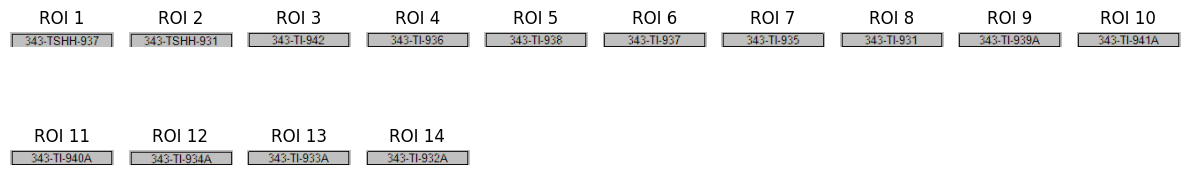

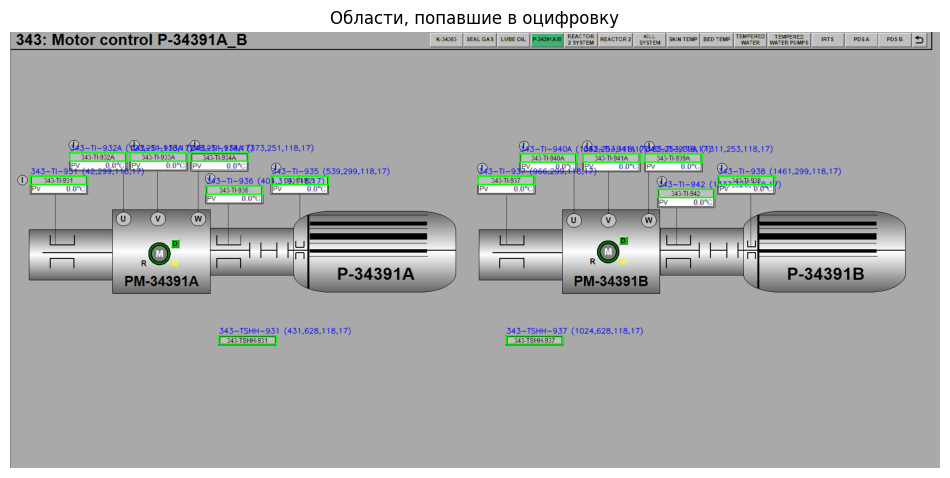

Сенсор 1: '343-TSHH-937' (score: 1.00) - координаты: x=1024, y=628, w=118, h=17
Сенсор 2: '343-TSHH-931' (score: 1.00) - координаты: x=431, y=628, w=118, h=17
Сенсор 3: '343-TI-942' (score: 0.99) - координаты: x=1337, y=326, w=118, h=17
Сенсор 4: '343-TI-936' (score: 0.96) - координаты: x=404, y=319, w=118, h=17
Сенсор 5: '343-TI-938' (score: 0.99) - координаты: x=1461, y=299, w=118, h=17
Сенсор 6: '343-TI-937' (score: 0.95) - координаты: x=966, y=299, w=118, h=17
Сенсор 7: '343-TI-935' (score: 0.99) - координаты: x=539, y=299, w=118, h=17
Сенсор 8: '343-Tl-931' (score: 0.96) - координаты: x=42, y=299, w=118, h=17
Сенсор 9: '343-TI-939A' (score: 0.99) - координаты: x=1311, y=253, w=118, h=17
Сенсор 10: '343-TI-941A' (score: 1.00) - координаты: x=1183, y=253, w=118, h=17
Сенсор 11: '343-TI-940A' (score: 1.00) - координаты: x=1052, y=253, w=118, h=17
Сенсор 12: '343-TI-934A' (score: 0.97) - координаты: x=373, y=251, w=118, h=17
Сенсор 13: '343-TI-933A' (score: 0.99) - координаты: x=248, 

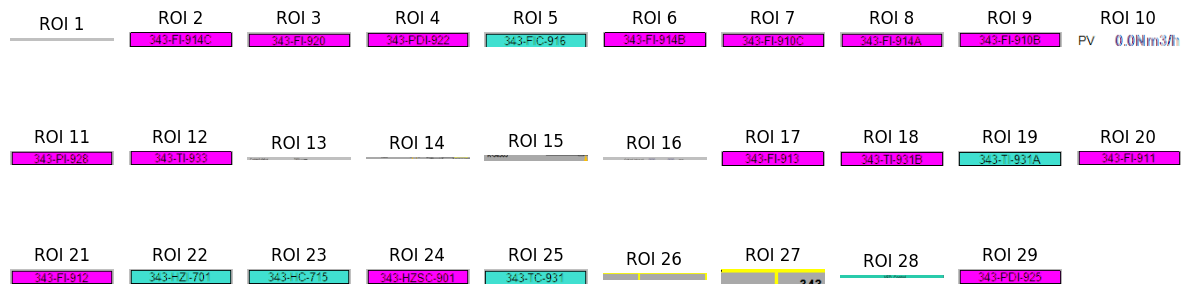

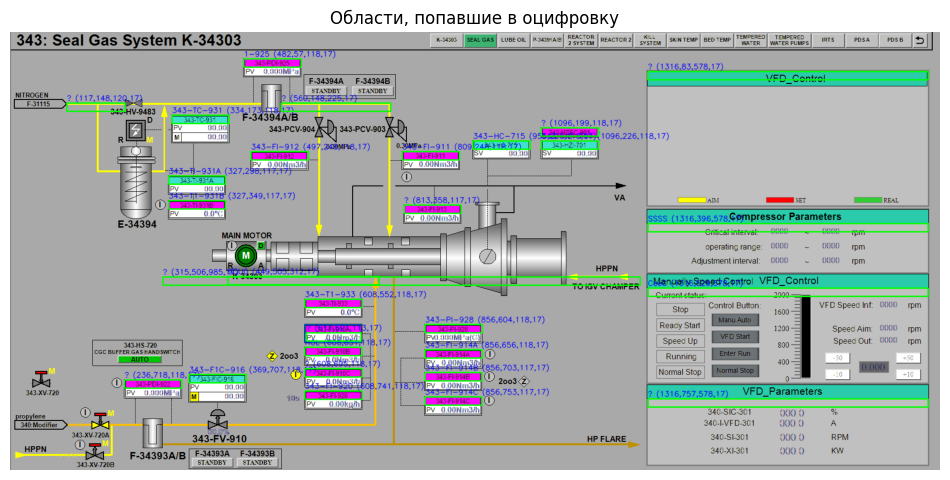

Сенсор 1: '?' (score: 0.00) - координаты: x=1316, y=757, w=578, h=17
Сенсор 2: '343-FI-914C' (score: 0.96) - координаты: x=856, y=753, w=117, h=17
Сенсор 3: '343-FI-920' (score: 0.94) - координаты: x=608, y=741, w=118, h=17
Сенсор 4: '?' (score: 0.00) - координаты: x=236, y=718, w=118, h=17
Сенсор 5: '343-F1C-916' (score: 0.97) - координаты: x=369, y=707, w=118, h=17
Сенсор 6: '343-FI-914B' (score: 0.94) - координаты: x=856, y=703, w=117, h=17
Сенсор 7: '?' (score: 0.00) - координаты: x=608, y=695, w=118, h=17
Сенсор 8: '343-FI-914A' (score: 0.95) - координаты: x=856, y=656, w=118, h=17
Сенсор 9: 'HOL' (score: 0.94) - координаты: x=608, y=651, w=118, h=17
Сенсор 10: '?' (score: 0.00) - координаты: x=611, y=621, w=113, h=17
Сенсор 11: '343-PI-928' (score: 0.97) - координаты: x=856, y=604, w=118, h=17
Сенсор 12: '343-T1-933' (score: 0.96) - координаты: x=608, y=552, w=118, h=17
Сенсор 13: 'CeeC' (score: 0.35) - координаты: x=1316, y=529, w=578, h=17
Сенсор 14: '?' (score: 0.00) - координ

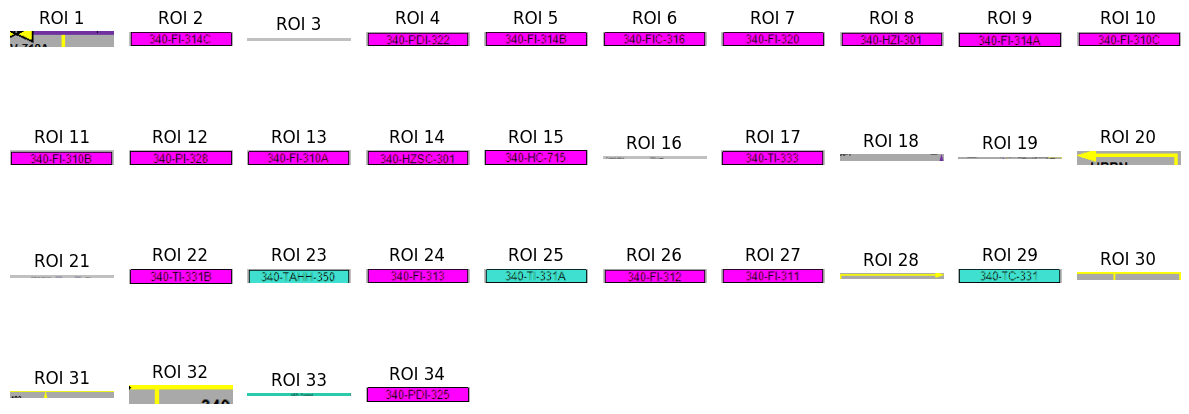

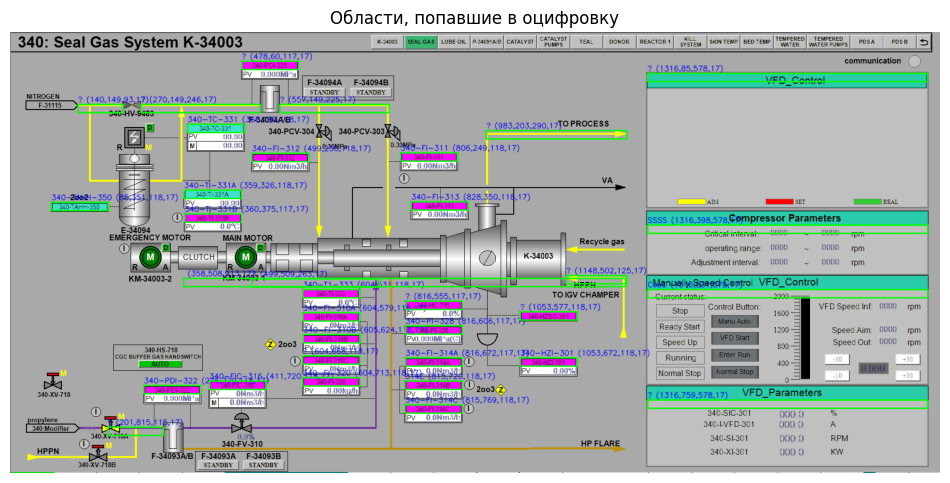

Сенсор 1: '?' (score: 0.00) - координаты: x=201, y=815, w=115, h=17
Сенсор 2: '340-Fl-314C' (score: 0.97) - координаты: x=815, y=769, w=118, h=17
Сенсор 3: '?' (score: 0.00) - координаты: x=1316, y=759, w=578, h=17
Сенсор 4: '340-PDI-322' (score: 0.98) - координаты: x=276, y=729, w=118, h=17
Сенсор 5: '314E' (score: 0.84) - координаты: x=815, y=720, w=118, h=17
Сенсор 6: '340-FIC-316' (score: 1.00) - координаты: x=411, y=720, w=118, h=17
Сенсор 7: '340-Fl-320' (score: 0.98) - координаты: x=604, y=713, w=118, h=17
Сенсор 8: '340-HZI-301' (score: 1.00) - координаты: x=1053, y=672, w=118, h=17
Сенсор 9: '340-FI-314A' (score: 0.98) - координаты: x=816, y=672, w=117, h=17
Сенсор 10: '?' (score: 0.00) - координаты: x=604, y=668, w=118, h=17
Сенсор 11: '340-FI-310B' (score: 0.97) - координаты: x=605, y=624, w=118, h=17
Сенсор 12: '340-PI-328' (score: 0.97) - координаты: x=816, y=606, w=117, h=17
Сенсор 13: '340-FI-310A' (score: 0.97) - координаты: x=604, y=579, w=118, h=17
Сенсор 14: '?' (sco

In [9]:
# Пути
main_output_dir = "/Users/haykarutyunyan/Documents/work_dgp_mnemo"
docx_input_dir = "/Users/haykarutyunyan/Documents/work_dgp_mnemo/mnemo_doc"
png_output_dir = "/Users/haykarutyunyan/Documents/work_dgp_mnemo/raw_mnemo_png"
cropped_title_output_dir = "/Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_title"
cropped_output_dir = "/Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_png"
mask_output_dir = "/Users/haykarutyunyan/Documents/work_dgp_mnemo/crop_mnemo_mask"

# --- 1. Извлечение PNG из DOCX ---
#extract_images_from_docx_folder(docx_input_dir, png_output_dir)

# --- 3. Функция обработки всех PNG и запись в Excel ---
def process_all_images_to_excel(input_dir, output_dir, ocr, excel_filename="results.xlsx"):
    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, excel_filename)
    results = []

    for img_file in os.listdir(input_dir):
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue

        cropped_img_path = os.path.join(input_dir, img_file)
        cropped_img = cv2.imread(cropped_img_path)
        if cropped_img is None:
            print(f"❌ Ошибка чтения кропнутого файла: {cropped_img_path}")
            continue
        
        # --- Кроп заголовка ---
        title_cropped = crop_title_from_cropped_image(cropped_img)
        
        # Сохраняем для визуального контроля (опционально)
        name, ext = os.path.splitext(img_file)
        title_crop_path = os.path.join(cropped_title_output_dir, f"{name}_title{ext}")
        cv2.imwrite(title_crop_path, title_cropped)
        
        # --- Оцифровка заголовка ---
        title = extract_title_from_crop_image(title_cropped)

        # --- Удаление линий ---
        img_cleaned = remove_blue_lines_inpaint(cropped_img)

        # --- Извлечение сенсоров ---
        sensors = extract_sensors_no_quadrants(img_cleaned, input_path=img_file, ocr=ocr)

        # --- Сохраняем результаты ---
        for sensor in sensors:
            results.append({
                "filename": os.path.splitext(img_file)[0].replace("_cropped", ""),
                "title": title,
                "sensor_name": sensor["text"]
            })

    if not results:
        print("⚠️ Нет результатов для записи.")
        return

    df = pd.DataFrame(results, columns=["filename", "title", "sensor_name"])
    df.to_excel(excel_path, index=False, engine="openpyxl")
    print(f"\n✅ Обработка завершена. Excel сохранён: {excel_path}")
    os.system('afplay /System/Library/Sounds/Glass.aiff')


# --- 4. Запуск пайплайна ---
# Кроп всех изображений
crop_and_save_images(png_output_dir, cropped_output_dir)

# Обработка кропа → Excel + маски
process_all_images_to_excel(cropped_output_dir, main_output_dir, ocr)